   target  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  
Data shape: (398, 8)
target          0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
Missing value: target          0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


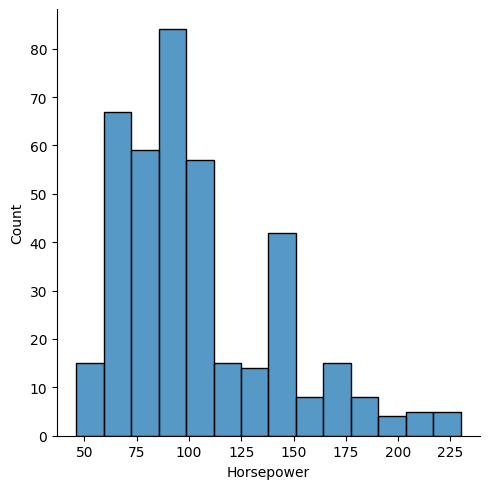

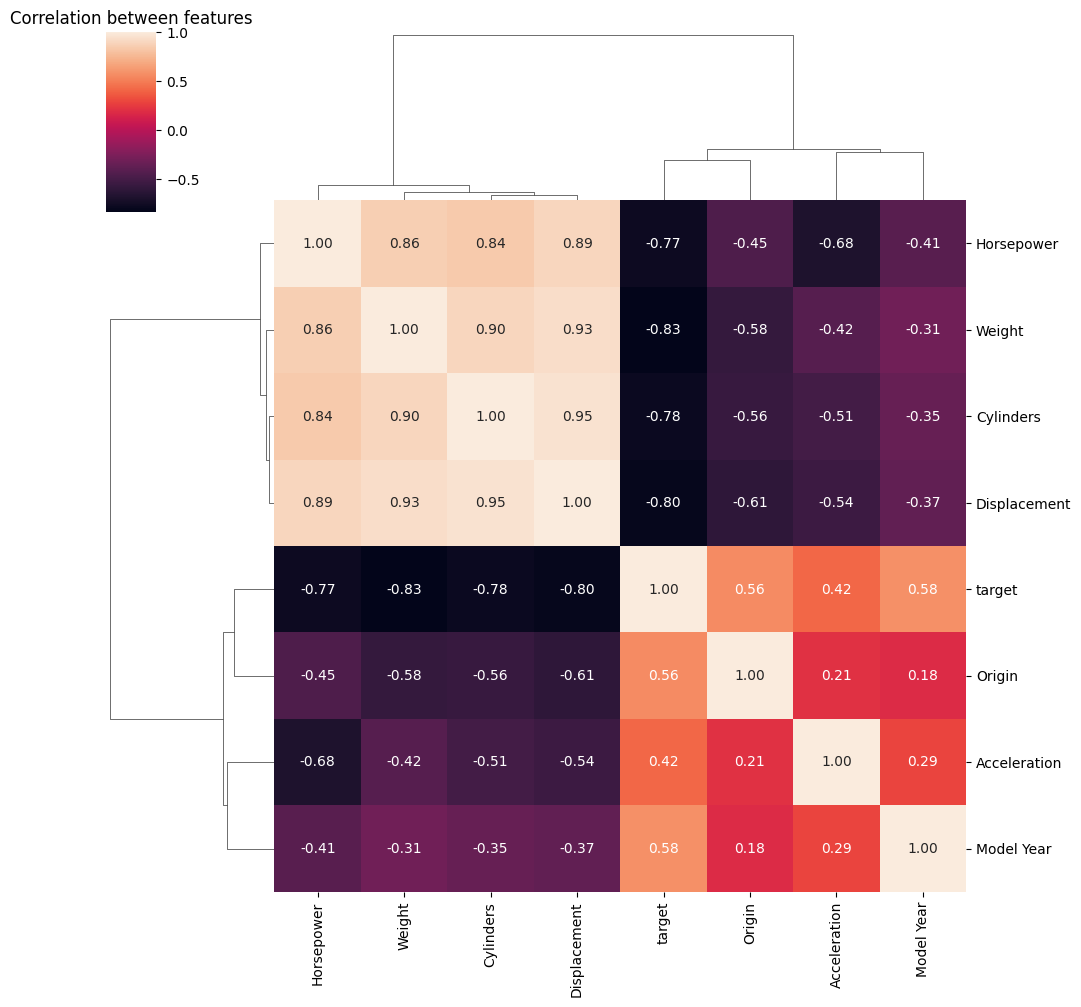

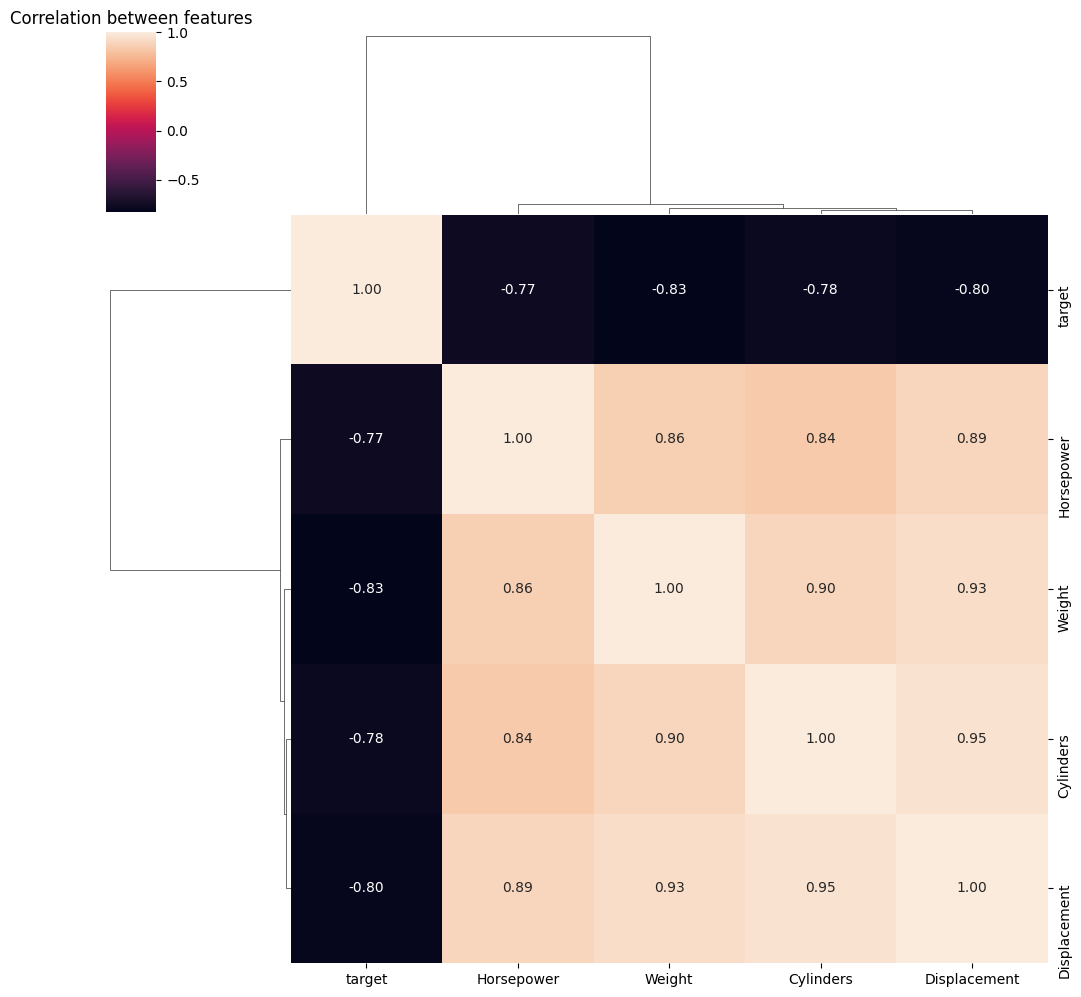

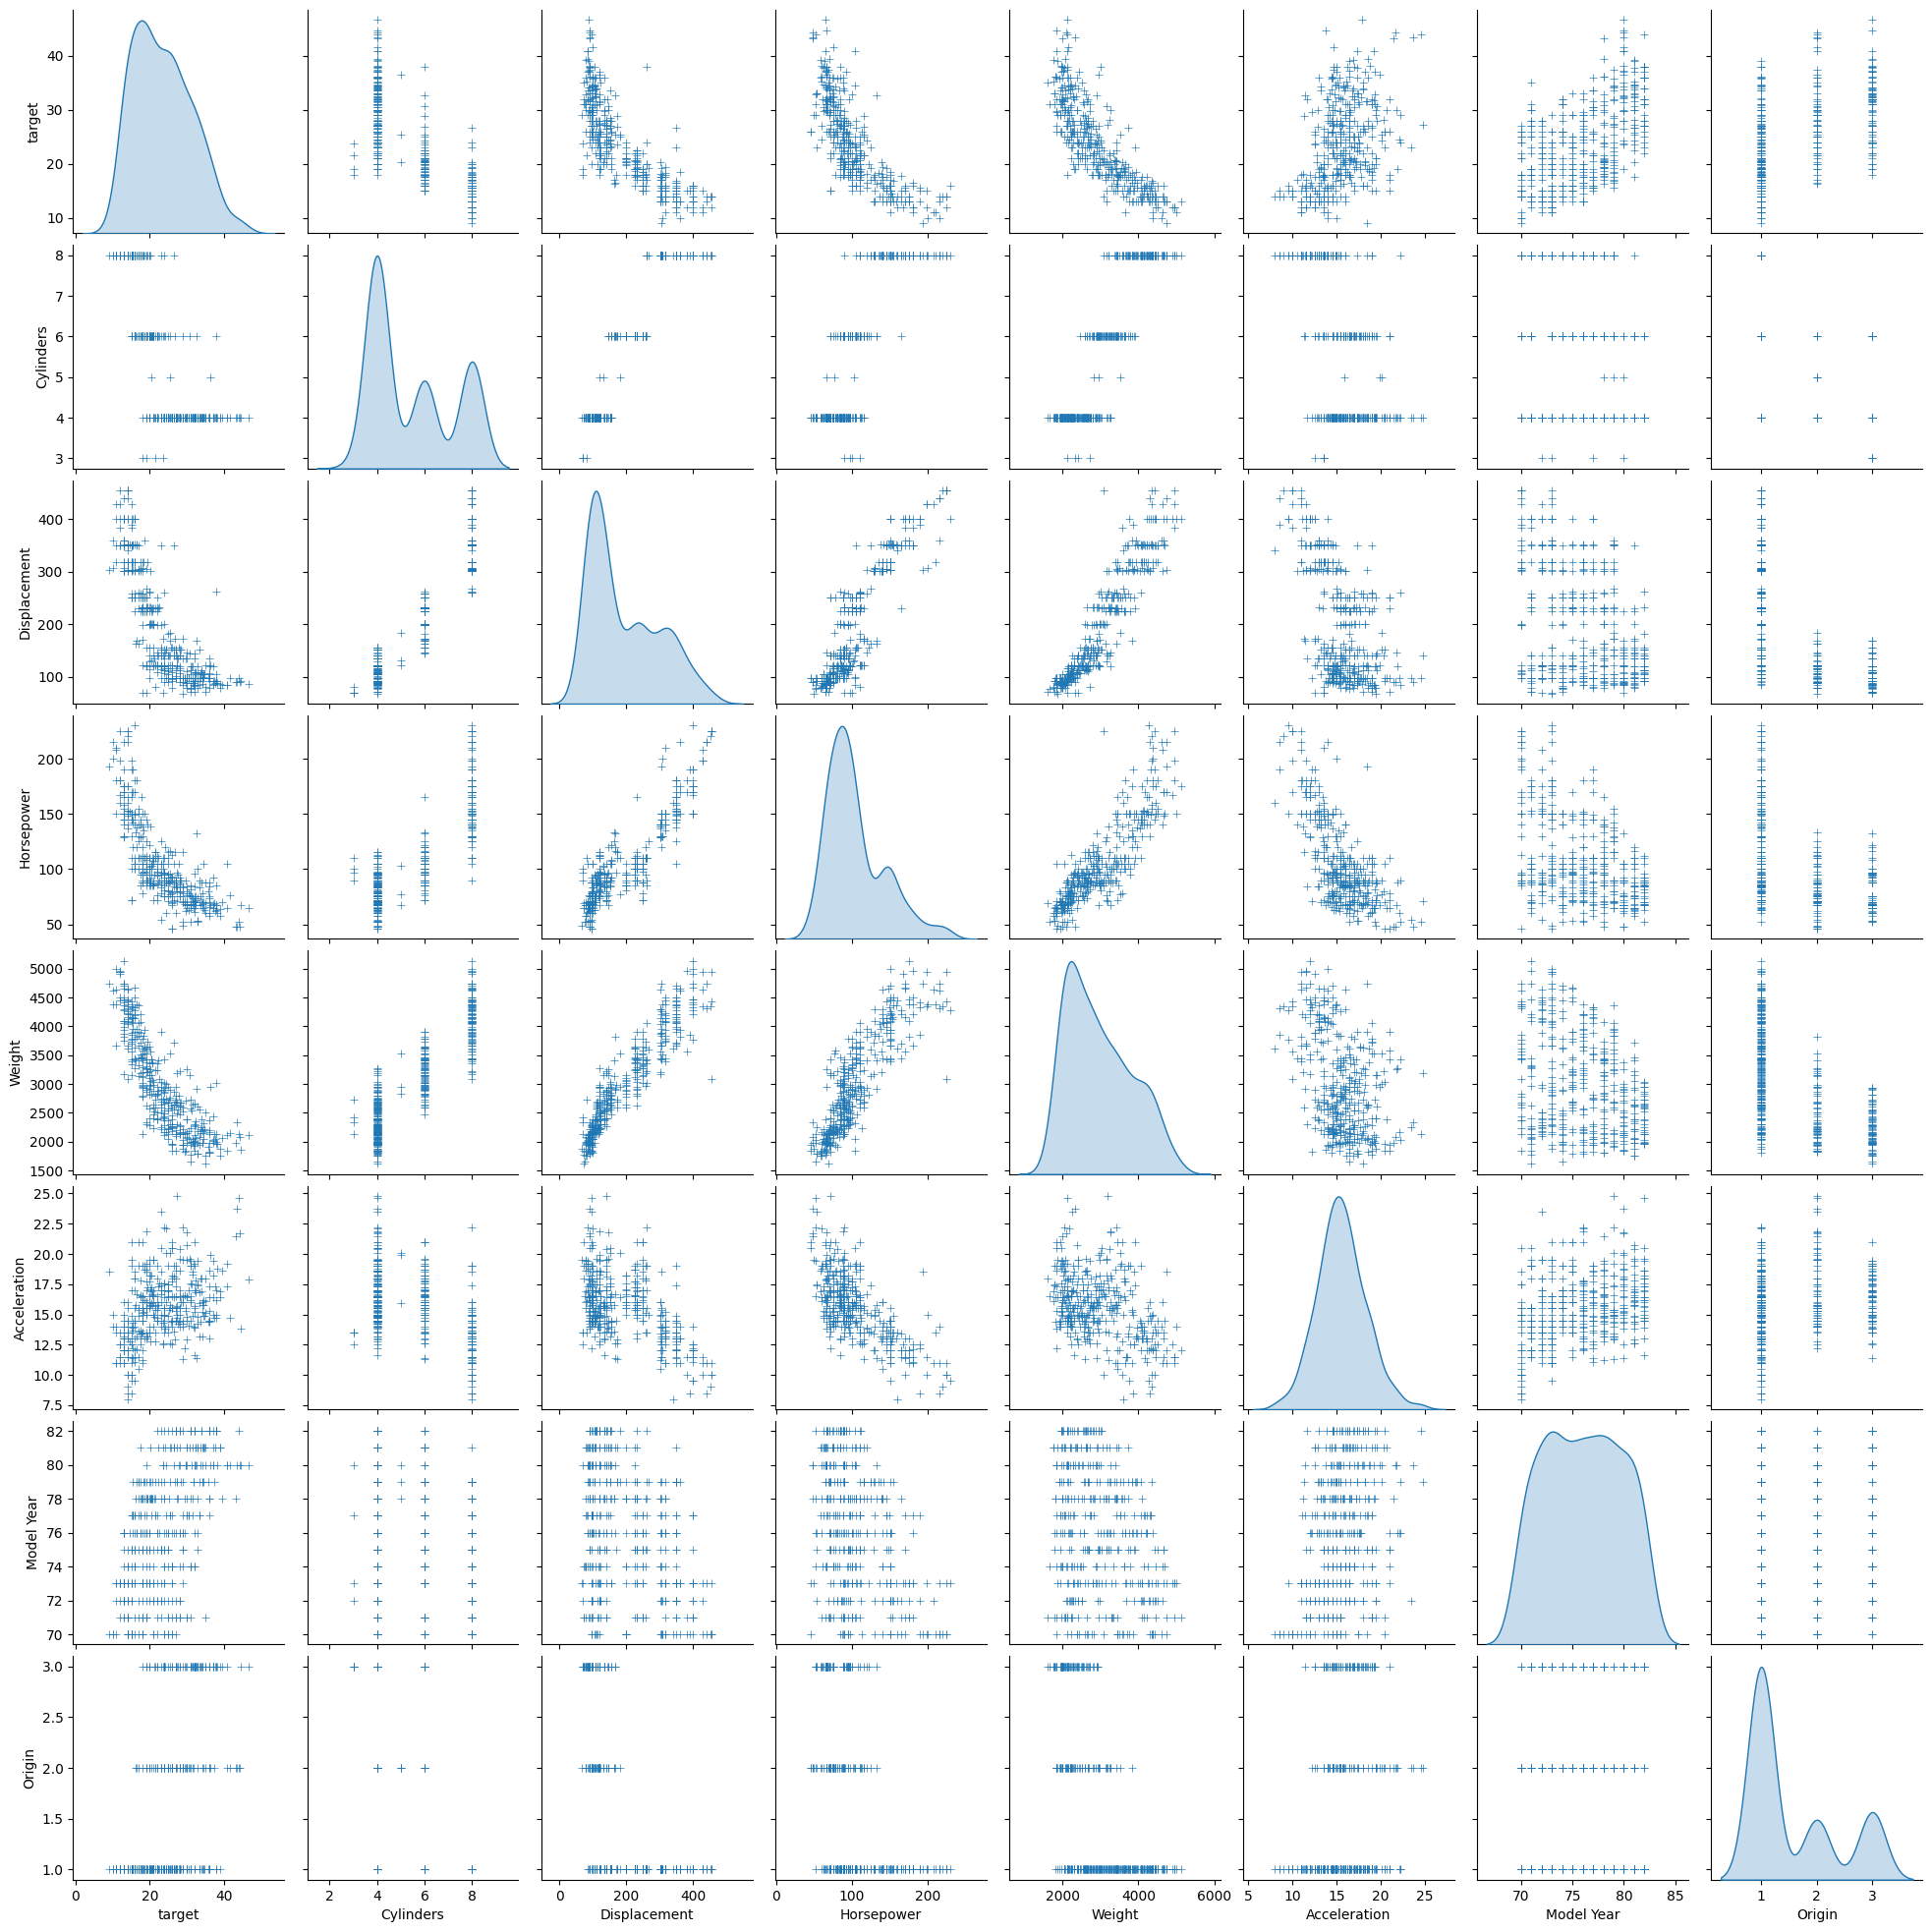

4    204
8    103
6     84
3      4
5      3
Name: Cylinders, dtype: int64
1    249
3     79
2     70
Name: Origin, dtype: int64


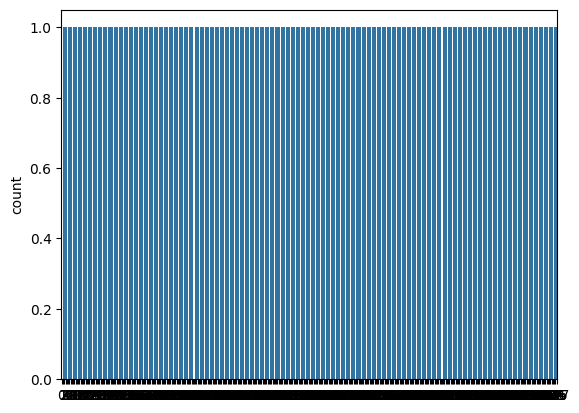

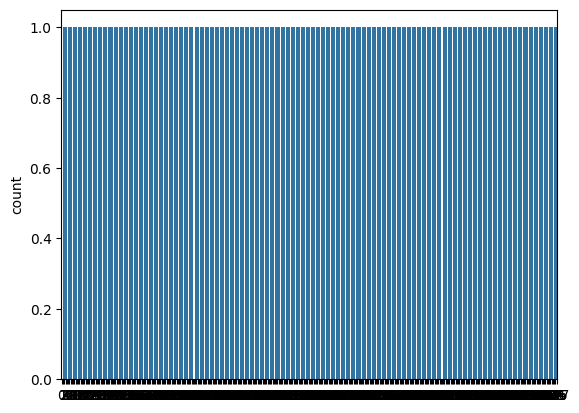

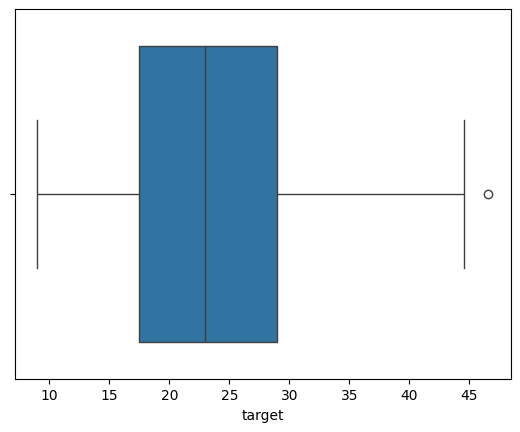

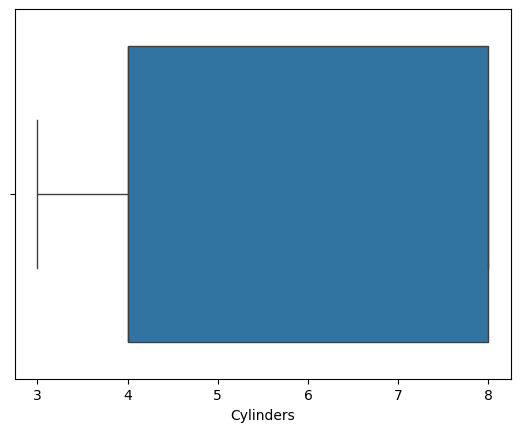

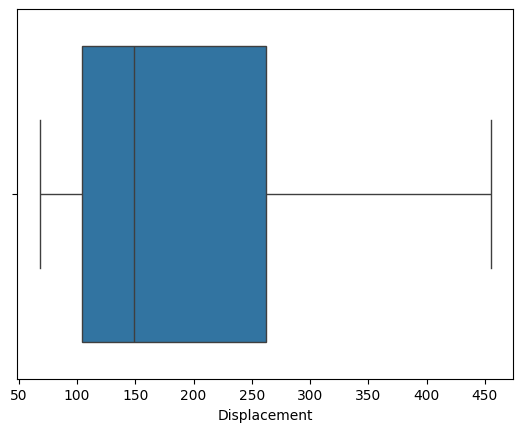

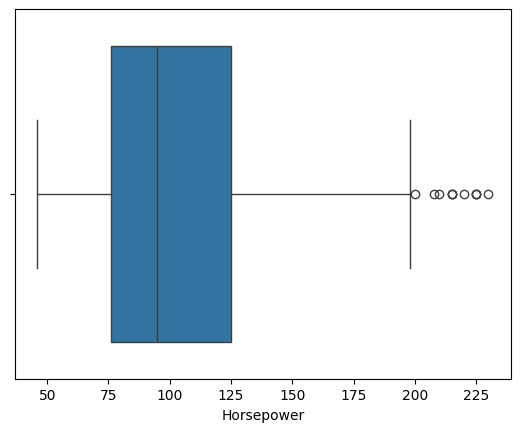

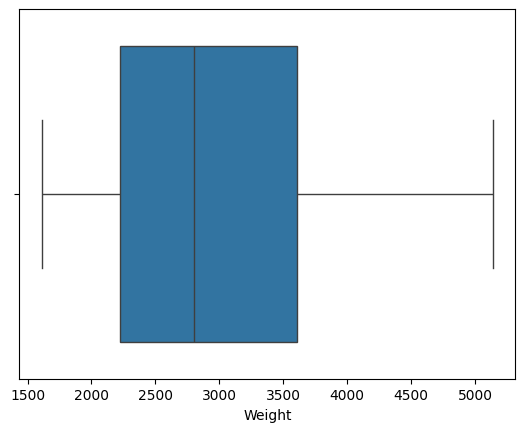

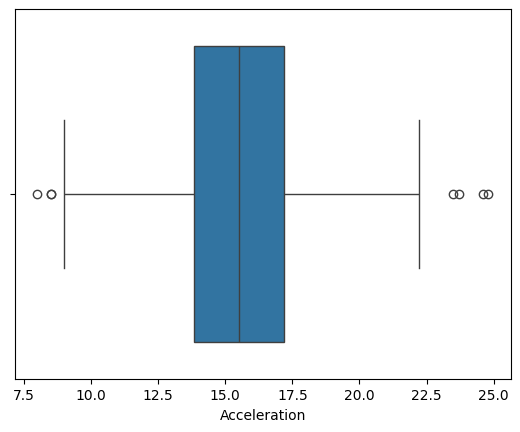

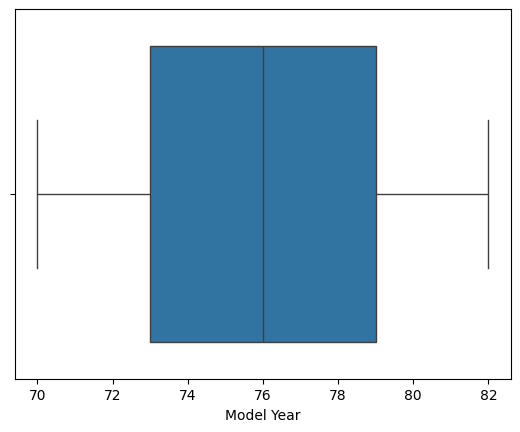

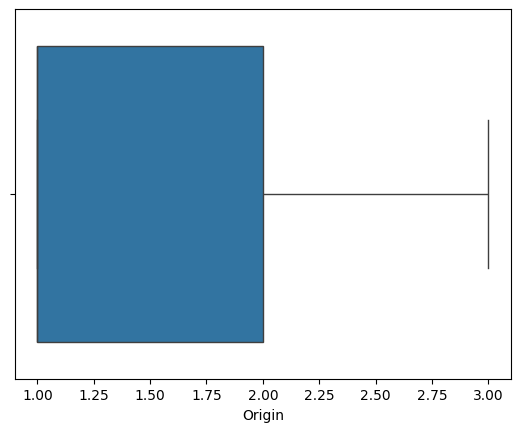

mu: 23.472405063291134, sigma: 7.756119546409932


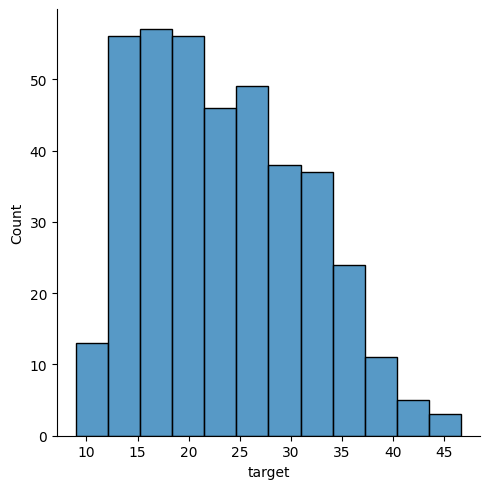

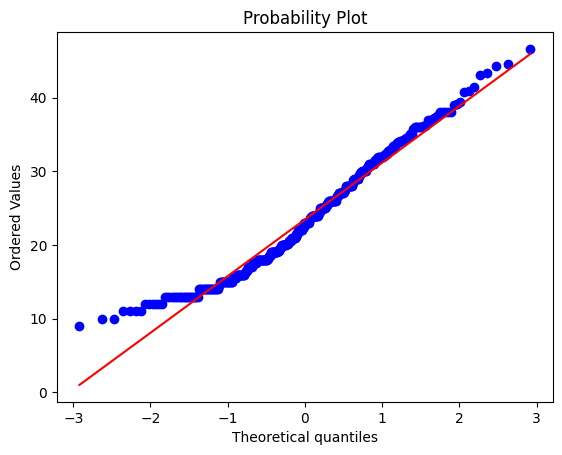

LR Coef [ 1.40061152 -1.34866348 -4.48093376 -0.18572695  2.57619474 -0.69326009
  0.85716531  0.25001277 -0.77866858 -0.12664272 -0.58245654 -0.04145333
  0.73682663]
Linear Regression MSE:  12.755888497853011
Ridge Coef: [ 1.32872    -1.35131798 -4.4281478  -0.19446677  2.56974923 -0.69896676
  0.85091091  0.2481336  -0.77819077 -0.11805192 -0.57929419 -0.04564227
  0.7368985 ]
Ridge MSE:  12.775251152235397
Lasso Coef: [-0.         -0.7087563  -4.16244246 -0.          2.4849321  -0.72735027
  0.43312221  0.08346002 -0.80339651 -0.         -0.34436014  0.
  0.72215864]
Lasso MSE:  12.582199056971547
ElasticNet Coef: [-0.         -0.76070203 -4.02701616 -0.          2.46810388 -0.71185112
  0.52418099  0.0949067  -0.77593127 -0.         -0.35012977  0.
  0.73760869]
ElasticNet MSE:  12.634400957766566
XGBRegressor MSE:  5.6112814544804115
Averaging Models MSE:  12.640818341960307


In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]
data = pd.read_csv("auto-mpg.data", names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)
data = data.rename(columns={"MPG": "target"})

print(data.head())
print("Data shape:", data.shape)

describe = data.describe()

# Missing value handling
print(data.isna().sum())
data["Horsepower"] = data["Horsepower"].fillna(data["Horsepower"].mean())
print("Missing value:", data.isna().sum())

sns.displot(data.Horsepower)

# EDA
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation between features")
plt.show()

threshold = 0.75
filter_ = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filter_].tolist()
sns.clustermap(data[corr_features].corr(), annot=True, fmt=".2f")
plt.title("Correlation between features")
plt.show()

sns.pairplot(data, diag_kind="kde", markers="+")
plt.show()


# Cylinders and origin can be treated as categorical variables (feature engineering)
plt.figure()
sns.countplot(data["Cylinders"])
print(data["Cylinders"].value_counts())

plt.figure()
sns.countplot(data["Origin"])
print(data["Origin"].value_counts())

# Boxplot for outlier detection
for c in data.columns:
    plt.figure()
    sns.boxplot(x=c, data=data, orient="v")
    plt.show()

# Outlier detection: Horsepower and Acceleration
thr = 2
horsepower_desc = describe["Horsepower"]
q3_hp = horsepower_desc[6]
q1_hp = horsepower_desc[4]
IQR_hp = q3_hp - q1_hp
top_limit_hp = q3_hp + thr * IQR_hp
bottom_limit_hp = q1_hp - thr * IQR_hp
filter_hp_bottom = bottom_limit_hp < data["Horsepower"]
filter_hp_top = data["Horsepower"] < top_limit_hp
filter_hp = filter_hp_bottom & filter_hp_top

data = data[filter_hp]

acceleration_desc = describe["Acceleration"]
q3_acc = acceleration_desc[6]
q1_acc = acceleration_desc[4]
IQR_acc = q3_acc - q1_acc
top_limit_acc = q3_acc + thr * IQR_acc
bottom_limit_acc = q1_acc - thr * IQR_acc
filter_acc_bottom = bottom_limit_acc < data["Acceleration"]
filter_acc_top = data["Acceleration"] < top_limit_acc
filter_acc = filter_acc_bottom & filter_acc_top

data = data[filter_acc]  # remove Acceleration outliers

# Feature engineering
# Skewness
sns.displot(data.target,)

(mu, sigma) = stats.norm.fit(data.target)
print("mu: {}, sigma: {}".format(mu, sigma))

plt.figure()
stats.probplot(data.target, plot=plt)
plt.show()

skew_feats = data.apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame(skew_feats, columns=["skewed"])

# Box-Cox transformation
data["Cylinders"] = data["Cylinders"].astype("category")
data["Origin"] = data["Origin"].astype(str)

data = pd.get_dummies(data)

# Split data and standardization
X = data.drop(["target"], axis=1)
y = data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Regression Models
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
print("LR Coef", lr.coef_)
y_predicted_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_predicted_lr)
print("Linear Regression MSE: ", mse_lr)

# Ridge Regression (L2)
ridge = Ridge(random_state=42, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)
param_grid = {"alpha": alphas}
clf_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring="neg_mean_squared_error", refit=True)
clf_ridge.fit(X_train, y_train)

print("Ridge Coef:", clf_ridge.best_estimator_.coef_)
y_predicted_ridge = clf_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_predicted_ridge)
print("Ridge MSE: ", mse_ridge)

# Lasso Regression (L1)
lasso = Lasso(random_state=42, max_iter=10000)
param_grid = {"alpha": alphas}
clf_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring="neg_mean_squared_error", refit=True)
clf_lasso.fit(X_train, y_train)

print("Lasso Coef:", clf_lasso.best_estimator_.coef_)
y_predicted_lasso = clf_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_predicted_lasso)
print("Lasso MSE: ", mse_lasso)

# ElasticNet
param_grid = {"alpha": alphas, "l1_ratio": np.arange(0.0, 1.0, 0.05)}
eNet = ElasticNet(random_state=42, max_iter=10000)
clf_eNet = GridSearchCV(eNet, param_grid, cv=5, scoring="neg_mean_squared_error", refit=True)
clf_eNet.fit(X_train, y_train)

print("ElasticNet Coef:", clf_eNet.best_estimator_.coef_)
y_predicted_eNet = clf_eNet.predict(X_test)
mse_eNet = mean_squared_error(y_test, y_predicted_eNet)
print("ElasticNet MSE: ", mse_eNet)

# XGBoost
param_grid = {'nthread': [4],
              'objective': ['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500, 1000]}

model_xgb = xgb.XGBRegressor()
clf_xgb = GridSearchCV(model_xgb, param_grid, cv=5, scoring="neg_mean_squared_error", refit=True, n_jobs=-1)
clf_xgb.fit(X_train, y_train)

y_predicted_xgb = clf_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_predicted_xgb)
print("XGBRegressor MSE: ", mse_xgb)

# Averaging Models
class AveragingModels():
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)


averaged_models = AveragingModels(models=(lr, clf_lasso.best_estimator_))
averaged_models.fit(X_train, y_train)

y_predicted_avg = averaged_models.predict(X_test)
mse_avg = mean_squared_error(y_test, y_predicted_avg)
print("Averaging Models MSE: ", mse_avg)
